## Прогнозирование ряда со сложной сезонностью

1. Выберите одну из зон среди отобранных на прошлой неделе, возьмите по ней все подготовленные данные о количестве поездок.Создайте регрессионные признаки для учёта сезонностей и трендов.

In [149]:
import pandas as pd
pd.options.mode.chained_assignment = None
import numpy as np

import matplotlib.pyplot as plt
plt.style.use('bmh')
plt.rcParams["figure.figsize"] = (15,8)

In [150]:
data = pd.read_csv('taxi_agg_2016.csv')
data.head()

,tpep_pickup_datetime,region,trips_number
0,2016-05-01 00,1014,1
1,2016-05-01 00,1016,1
2,2016-05-01 00,1028,3
3,2016-05-01 00,1029,1
4,2016-05-01 00,1032,4


In [151]:
data_region = data.loc[data['region']==1281]
data_region.head()

,tpep_pickup_datetime,region,trips_number
67,2016-05-01 00,1281,751
288,2016-05-01 01,1281,601
520,2016-05-01 02,1281,388
734,2016-05-01 03,1281,307
937,2016-05-01 04,1281,160


<AxesSubplot:>

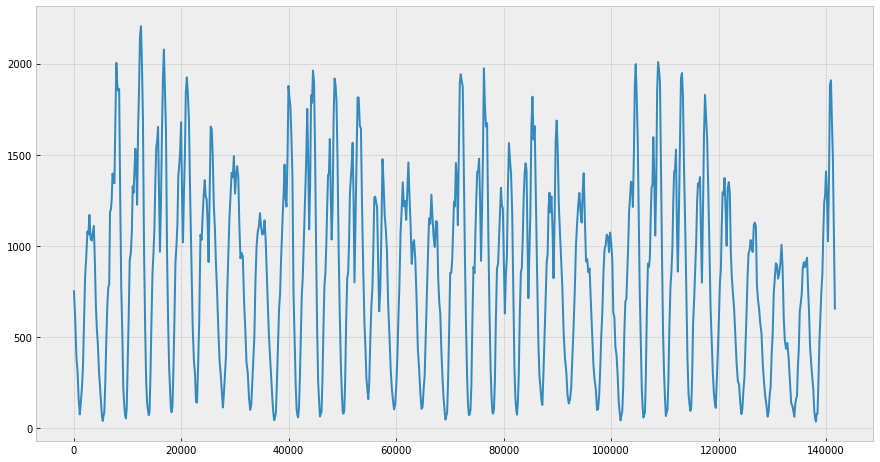

In [152]:
data_region['trips_number'].plot()

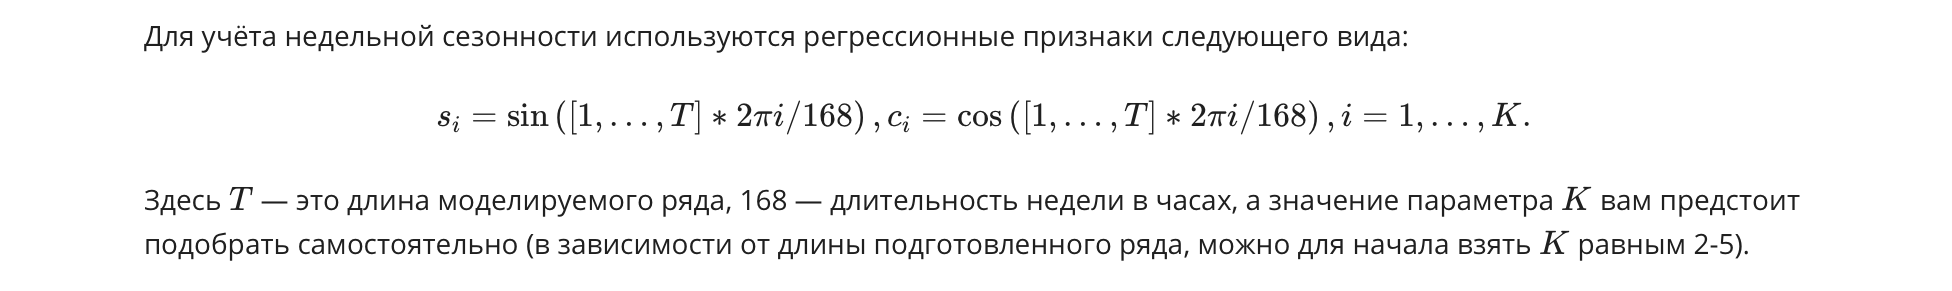

In [153]:
m = 169
n = len(data_region)
for i in range(1, m):
    sin = "sin_" + str(i)
    cos = "cos_" + str(i)
    data_region[sin] = np.sin(2*np.pi*i*np.arange(1, n+1)/168.0)
    data_region[cos] = np.cos(2*np.pi*i*np.arange(1, n+1)/168.0)

Добавим ещё некоторые экзогенные признаки: день недели и час

In [154]:
# data_region['day'] = pd.to_datetime(data_region['tpep_pickup_datetime']).dt.dayofweek
# data_region['hour'] = pd.to_datetime(data_region['tpep_pickup_datetime']).dt.hour

In [155]:
data_region.head()

,tpep_pickup_datetime,region,trips_number,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,...,sin_164,cos_164,sin_165,cos_165,sin_166,cos_166,sin_167,cos_167,sin_168,cos_168
67,2016-05-01 00,1281,751,0.037391,0.999301,0.074730,0.997204,0.111964,0.993712,0.149042,...,-0.149042,0.988831,-0.111964,0.993712,-0.074730,0.997204,-0.037391,0.999301,-2.449294e-16,1.0
288,2016-05-01 01,1281,601,0.074730,0.997204,0.149042,0.988831,0.222521,0.974928,0.294755,...,-0.294755,0.955573,-0.222521,0.974928,-0.149042,0.988831,-0.074730,0.997204,-4.898587e-16,1.0
520,2016-05-01 02,1281,388,0.111964,0.993712,0.222521,0.974928,0.330279,0.943883,0.433884,...,-0.433884,0.900969,-0.330279,0.943883,-0.222521,0.974928,-0.111964,0.993712,-7.347881e-16,1.0
734,2016-05-01 03,1281,307,0.149042,0.988831,0.294755,0.955573,0.433884,0.900969,0.563320,...,-0.563320,0.826239,-0.433884,0.900969,-0.294755,0.955573,-0.149042,0.988831,-9.797174e-16,1.0
937,2016-05-01 04,1281,160,0.185912,0.982566,0.365341,0.930874,0.532032,0.846724,0.680173,...,-0.680173,0.733052,-0.532032,0.846724,-0.365341,0.930874,-0.185912,0.982566,-1.224647e-15,1.0


2. Чтобы примерно подобрать порядки дифференцирования ряда в модели ARIMA, сделайте регрессию целевого признака — количества поездок — на построенные признаки. Посмотрите на остатки регрессии. Если регрессионные признаки подобраны идеально, то в них должна остаться только внутрисуточная сезонность. Вслепую идеально подобрать признаки вам вряд ли удастся, так что в остатках вы, скорее всего, увидите много интересного, в том числе праздники, аномалии, тренды и многое другое.


In [156]:
from sklearn.linear_model import LinearRegression

In [157]:
X = data_region.drop(columns=['tpep_pickup_datetime', 'region', 'trips_number'])
y = data_region['trips_number']

In [158]:
model = LinearRegression()
model.fit(X, y)

LinearRegression()

In [159]:
predictions = model.predict(X)

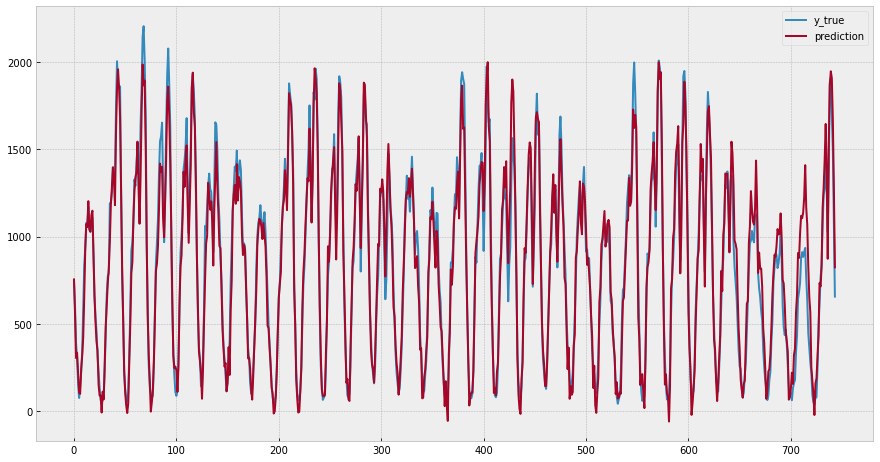

In [160]:
plt.plot(np.arange(0,744), y, label='y_true')
plt.plot(np.arange(0,744), predictions, label='prediction')
plt.legend()
plt.show()

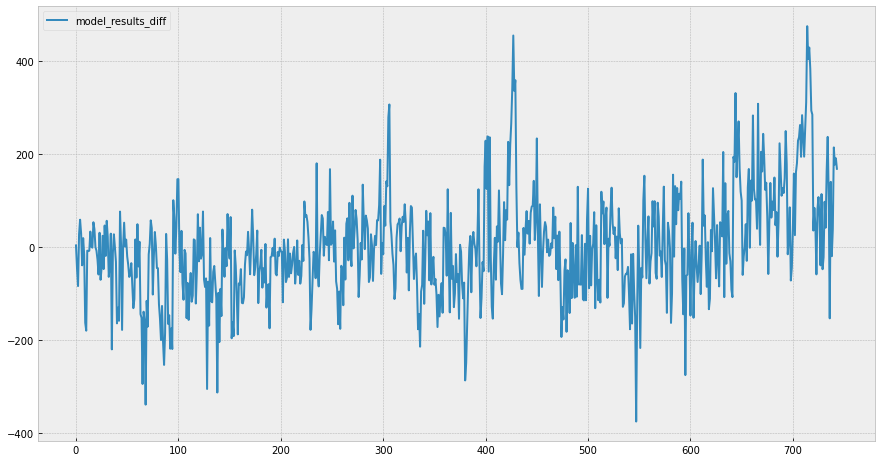

In [161]:
plt.plot(np.arange(0,744), predictions - y , label='model_results_diff')
plt.legend()
plt.show()

In [162]:
data_region['e'] = predictions - y

3. Чтобы подобрать значения гиперпараметров ARIMA, попробуйте сделать ряд остатков стационарным. Если необходимо, сделайте несколько дифференцирований. Из-за большого количества аномальных дней (праздники и т.д.) вряд ли вам удастся сделать так, что критерий Дики-Фуллера не будет отвергать гипотезу нестационарности, поэтому при выборе порядка дифференцирования ориентируйтесь в первую очередь на результат STL-декомпозиции.

In [163]:
import statsmodels.api as sm

In [218]:
data_reg_ind = data_region.dropna()
data_reg_ind = data_reg_ind.set_index('tpep_pickup_datetime')
data_reg_ind.index = pd.DatetimeIndex(data_reg_ind.index, freq='H')

Критерий Дики-Фуллера: p=0.000042


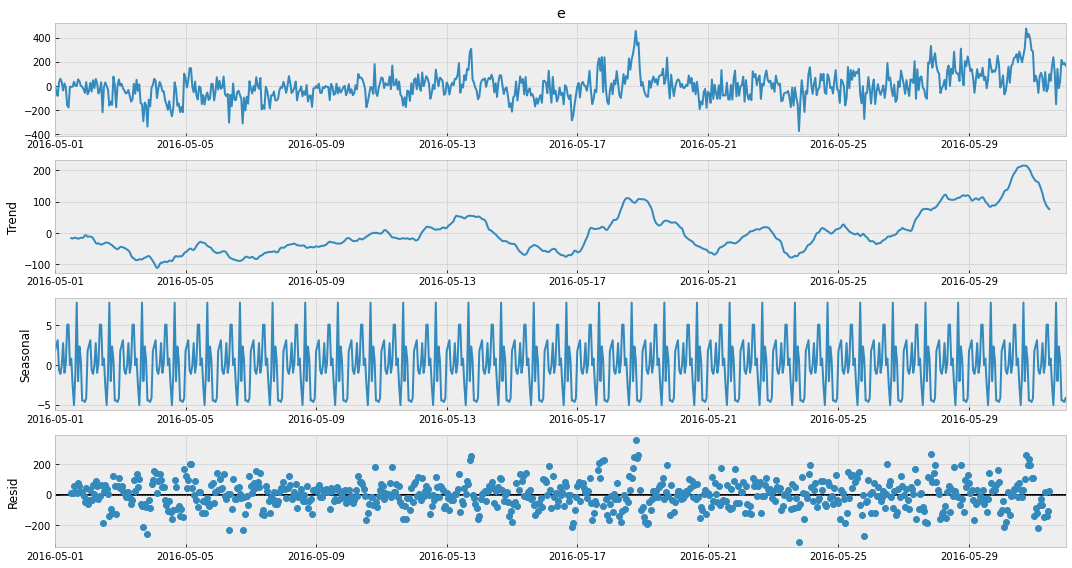

In [219]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_reg_ind['e'])[1])
sm.tsa.seasonal_decompose(data_reg_ind['e']).plot()
plt.show()

В остатках наблюдается дневная сезонность, попробуем избавиться от неё сезонным дифференцированием

In [220]:
data_reg_ind['seasonal_diff'] = data_reg_ind['e'].diff(24)

In [221]:
data_reg_ind = data_reg_ind.dropna()

Критерий Дики-Фуллера: p=0.000001


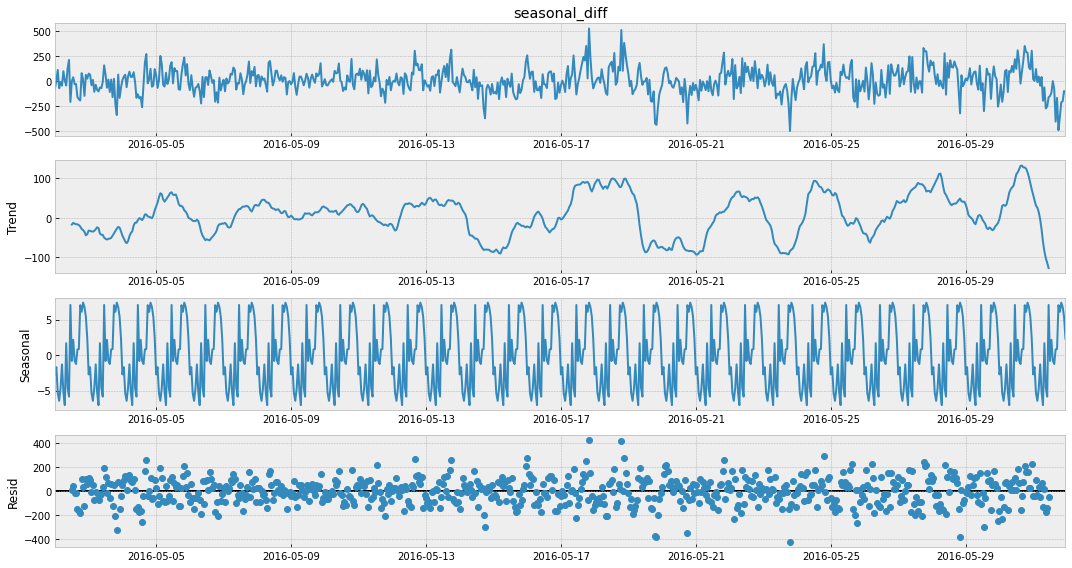

In [222]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_reg_ind['seasonal_diff'])[1])
sm.tsa.seasonal_decompose(data_reg_ind['seasonal_diff']).plot()
plt.show()

In [223]:
data_reg_ind['lag1_diff'] = data_reg_ind['seasonal_diff'].diff(1)

In [224]:
data_reg_ind = data_reg_ind.dropna()

Критерий Дики-Фуллера: p=0.000000


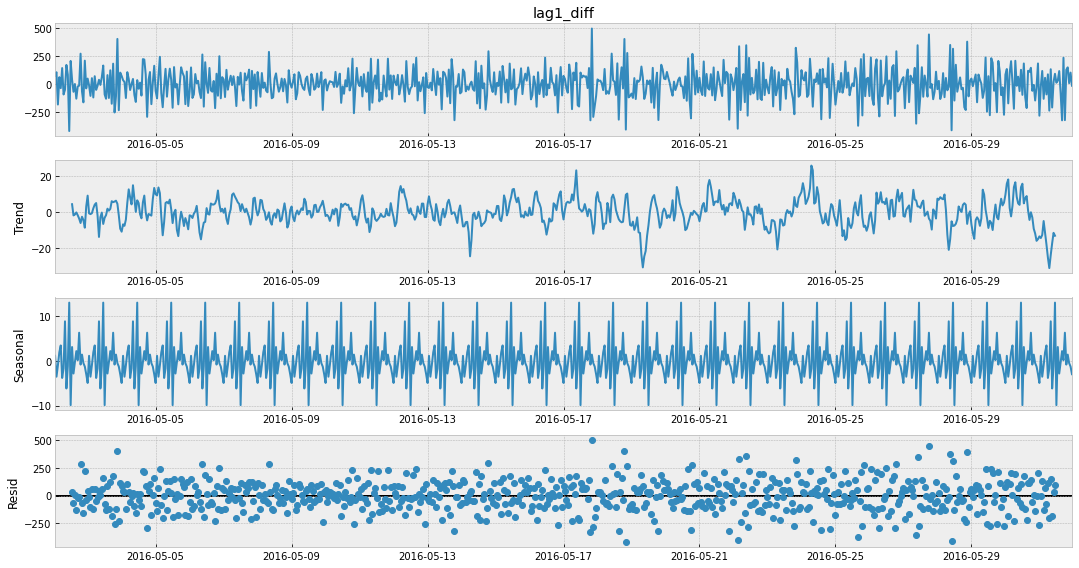

In [225]:
print("Критерий Дики-Фуллера: p=%f" % sm.tsa.stattools.adfuller(data_reg_ind['lag1_diff'])[1])
sm.tsa.seasonal_decompose(data_reg_ind['lag1_diff']).plot()
plt.show()

4. Постройте ACF и PACF полученного ряда остатков (возможно, продифференцированных) с максимальным лагом не меньше длины самого длинного сезонного периода (неделя или год), подберите по ним начальные приближения для параметров 

In [204]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

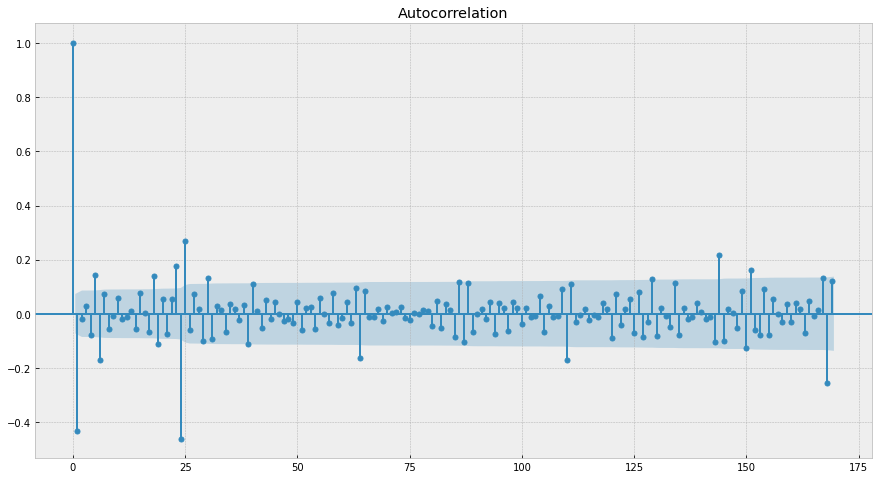

In [226]:
plot_acf(data_reg_ind['lag1_diff'].dropna(), lags=169)
plt.show()

In [227]:
q = 1 # последний значимый лаг автокорреляции
Q = 1 # последний значимый сезонный лаг автокорреляции, деленный на период сезонности 

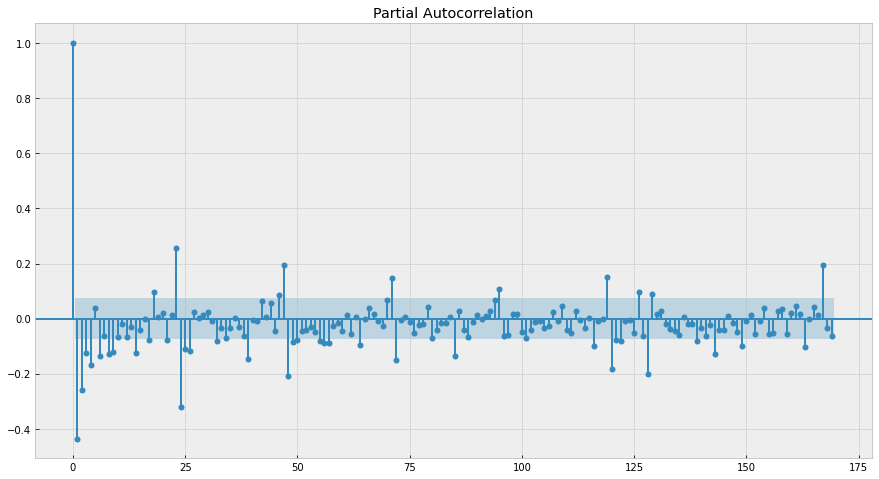

In [228]:
plot_pacf(data_reg_ind['lag1_diff'].dropna(), lags=169)
plt.show()

In [229]:
p = 4 # последний значимый лаг частной автокорреляции
P = 3 # последний значимый сезонный лаг частной автокорреляции, деленный на период сезонности

5. Используйте эти начальные приближения при переборе моделей ARIMA исходного ряда, не забывая подавать функции SARIMAX регрессионные признаки в качестве параметра exog.
Выберите оптимальную по AIC модель; постройте график исходного ряда и нарисуйте поверх предсказания выбранной модели. Если модель плохо описывает данные, попробуйте увеличить количество синусов и косинусов или поменять порядки дифференцирования.




In [230]:
from itertools import product

In [231]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [232]:
data_reg_ind.drop(columns=['region', 'trips_number', 'e', 'seasonal_diff', 'lag1_diff'])

,sin_1,cos_1,sin_2,cos_2,sin_3,cos_3,sin_4,cos_4,sin_5,cos_5,...,sin_164,cos_164,sin_165,cos_165,sin_166,cos_166,sin_167,cos_167,sin_168,cos_168
tpep_pickup_datetime,,,,,,,,,,,,,,,,,,,,,
2016-05-02 01:00:00,0.826239,0.563320,0.930874,-0.365341,2.225209e-01,-9.749279e-01,-0.680173,-0.733052,-0.988831,0.149042,...,0.680173,-0.733052,-2.225209e-01,-9.749279e-01,-0.930874,-0.365341,-0.826239,0.563320,7.842691e-15,1.0
2016-05-02 02:00:00,0.846724,0.532032,0.900969,-0.433884,1.119645e-01,-9.937122e-01,-0.781831,-0.623490,-0.943883,0.330279,...,0.781831,-0.623490,-1.119645e-01,-9.937122e-01,-0.900969,-0.433884,-0.846724,0.532032,-1.371852e-14,1.0
2016-05-02 03:00:00,0.866025,0.500000,0.866025,-0.500000,1.224647e-16,-1.000000e+00,-0.866025,-0.500000,-0.866025,0.500000,...,0.866025,-0.500000,2.449913e-14,-1.000000e+00,-0.866025,-0.500000,-0.866025,0.500000,-6.858022e-15,1.0
2016-05-02 04:00:00,0.884115,0.467269,0.826239,-0.563320,-1.119645e-01,-9.937122e-01,-0.930874,-0.365341,-0.757972,0.652287,...,0.930874,-0.365341,1.119645e-01,-9.937122e-01,-0.826239,-0.563320,-0.884115,0.467269,2.475923e-18,1.0
2016-05-02 05:00:00,0.900969,0.433884,0.781831,-0.623490,-2.225209e-01,-9.749279e-01,-0.974928,-0.222521,-0.623490,0.781831,...,0.974928,-0.222521,2.225209e-01,-9.749279e-01,-0.781831,-0.623490,-0.900969,0.433884,6.862974e-15,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2016-05-31 19:00:00,0.563320,-0.826239,-0.930874,0.365341,9.749279e-01,2.225209e-01,-0.680173,-0.733052,0.149042,0.988831,...,0.680173,-0.733052,-9.749279e-01,2.225209e-01,0.930874,0.365341,-0.563320,-0.826239,4.156082e-13,1.0
2016-05-31 20:00:00,0.532032,-0.846724,-0.900969,0.433884,9.937122e-01,1.119645e-01,-0.781831,-0.623490,0.330279,0.943883,...,0.781831,-0.623490,-9.937122e-01,1.119645e-01,0.900969,0.433884,-0.532032,-0.846724,1.666733e-13,1.0
2016-05-31 21:00:00,0.500000,-0.866025,-0.866025,0.500000,1.000000e+00,1.468957e-15,-0.866025,-0.500000,0.500000,0.866025,...,0.866025,-0.500000,-1.000000e+00,-6.492268e-13,0.866025,0.500000,-0.500000,-0.866025,-8.226160e-14,1.0


In [252]:
model_sarimax = SARIMAX(data_reg_ind['e'], 
                order=(p, 1, q), 
                seasonal_order=(P, 1, Q, 24)).fit()

In [253]:
model_sarimax.aic

8268.00327992878

In [259]:
q = 1 
Q = 1 
p = 4 
P = 3 

qs = range(1, 3)
ps = range(2, 5)
Ps = range(2, 4)
Qs = range(0, 1)

In [260]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

12

In [261]:
%%time
results = []
best_aic = float("inf")
# warnings.filterwarnings('ignore')

for param in parameters_list:
    #try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model=sm.tsa.statespace.SARIMAX(data_reg_ind['e'], 
                                        order=(param[0], 1, param[1]), 
                                        seasonal_order=(param[2], 1, param[3], 24)).fit(disp=-1)
    #выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    #сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])
    
# warnings.filterwarnings('default')

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


NameError: name 'warnings' is not defined

In [262]:
best_model

In [263]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

      parameters          aic
5   (3, 1, 3, 0)  8305.271519
3   (2, 2, 3, 0)  8305.449673
9   (4, 1, 3, 0)  8307.247054
11  (4, 2, 3, 0)  8309.226029
1   (2, 1, 3, 0)  8310.129629


In [264]:
model_sarimax = sm.tsa.statespace.SARIMAX(data_reg_ind['e'], 
                                        order=(3, 1, 1), 
                                        seasonal_order=(3, 1, 0, 24)).fit(disp=-1)

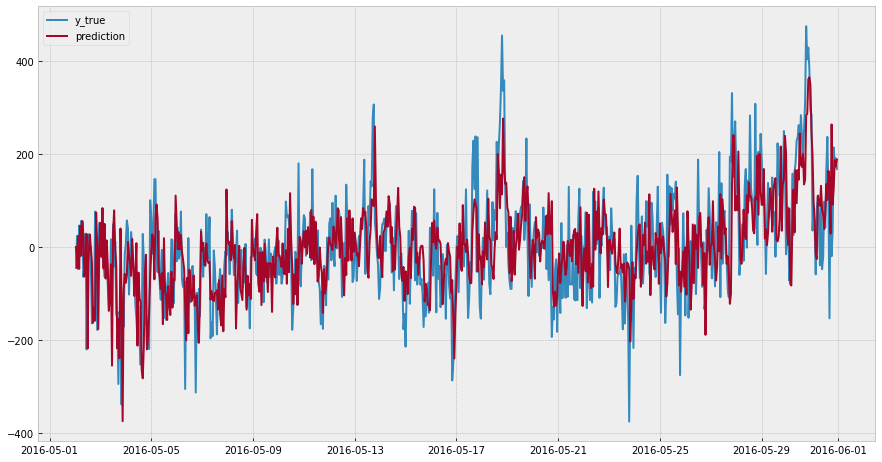

In [265]:
plt.plot(data_reg_ind['e'], label='y_true')
plt.plot(model_sarimax.fittedvalues, label='prediction')

plt.legend()
plt.show()

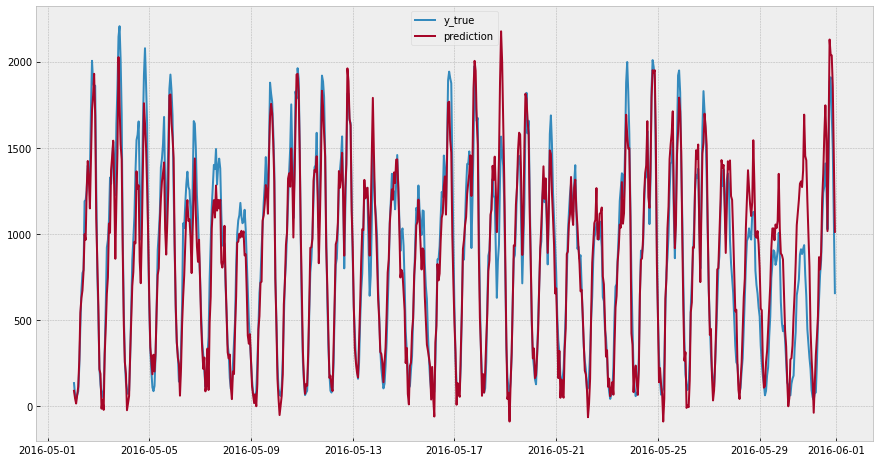

In [274]:
plt.plot(data_reg_ind['trips_number'], label='y_true')
plt.plot(model_sarimax.fittedvalues + predictions[-719:], label='prediction')
plt.legend()
plt.show()

6. Проанализируйте качество построенной модели. Опишите, в какие периоды она плохо описывает данные? Можно ли заранее предсказать её поведение в такие периоды и улучшить тем самым прогноз? Если да, попробуйте создать для таких периодов регрессионные признаки и вернитесь к пункту 2.
7. Загрузите ноутбук в форму.